In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpecFromSubplotSpec, GridSpec
import tqdm

## Load data

In [3]:
file_path = 'path to cocoa dijet_seg_bw0.4.root'

f = uproot.open(file_path)
tree = f['EventTree']
keys = tree.keys()
keys

['topo_eta',
 'topo_phi',
 'topo_e',
 'topo_rho',
 'topo_sigma_eta',
 'topo_sigma_phi',
 'topo_ms_cluster_idx',
 'topo_particle_idxs',
 'topo_particle_energies',
 'topo_ecal_e',
 'topo_hcal_e',
 'topo2particle_topo_idx',
 'topo2particle_particle_idx',
 'topo2particle_energy',
 'cell_eta',
 'cell_phi',
 'cell_e',
 'cell_calo_region',
 'cell_topo_idx',
 'cell_x',
 'cell_y',
 'cell_z',
 'track_eta',
 'track_phi',
 'track_pt',
 'track_ms_cluster_idx',
 'track_particle_idx',
 'track_z0',
 'track_d0',
 'track_x_layer_0',
 'track_x_layer_1',
 'track_x_layer_2',
 'track_x_layer_3',
 'track_x_layer_4',
 'track_x_layer_5',
 'track_y_layer_0',
 'track_y_layer_1',
 'track_y_layer_2',
 'track_y_layer_3',
 'track_y_layer_4',
 'track_y_layer_5',
 'track_z_layer_0',
 'track_z_layer_1',
 'track_z_layer_2',
 'track_z_layer_3',
 'track_z_layer_4',
 'track_z_layer_5',
 'track_eta_layer_0',
 'track_eta_layer_1',
 'track_eta_layer_2',
 'track_eta_layer_3',
 'track_eta_layer_4',
 'track_eta_layer_5',
 'track

In [4]:
n_events = tree.num_entries
print('n_events = {}'.format(n_events))

entry_start = 0; entry_stop = n_events

n_events = 965881


# Cardinality

In [7]:
### Loop over unique events in tree. Count the number of MS clusters, tracks, topoclusters, and particles per event.

cardinality_dict = {
    'n_tracks': [],
    'n_topoclusters': [],
    'n_particles': [],
    'n_ms_clusters': []
}

# relevant branches
track_eta = tree['track_eta'].array(library='np')
particle_pdgid = tree['particle_pdgid'].array(library='np')
topo_eta = tree['topo_eta'].array(library='np')

# get unique event numbers first
event_idx = tree['eventNumber'].array(library='np')
unique_events = np.unique(event_idx)

merge_ms_clusters = True

if merge_ms_clusters:
    for ev in tqdm.tqdm(unique_events):
        mask_ev = (event_idx == ev)
        track_eta_ev = np.hstack(track_eta[mask_ev])
        particle_pdgid_ev = np.hstack(particle_pdgid[mask_ev])
        particle_pdgid_ev = particle_pdgid_ev[np.abs(particle_pdgid_ev) != -999]
        topo_eta_ev = np.hstack(topo_eta[mask_ev])

        cardinality_dict['n_tracks'].append(len(track_eta_ev))
        cardinality_dict['n_particles'].append(len(particle_pdgid_ev))
        cardinality_dict['n_topoclusters'].append(len(topo_eta_ev))
        cardinality_dict['n_ms_clusters'].append(mask_ev.sum())

else:
    for ev in tqdm.tqdm(range(len(event_idx))):
        track_eta_ev = track_eta[ev]
        particle_pdgid_ev = particle_pdgid[ev]
        particle_pdgid_ev = particle_pdgid_ev[np.abs(particle_pdgid_ev) != -999]
        topo_eta_ev = topo_eta[ev]
        
        cardinality_dict['n_tracks'].append(len(track_eta_ev))
        cardinality_dict['n_particles'].append(len(particle_pdgid_ev))
        cardinality_dict['n_topoclusters'].append(len(topo_eta_ev))
        cardinality_dict['n_ms_clusters'].append(1)


100%|██████████| 35799/35799 [00:42<00:00, 839.92it/s]


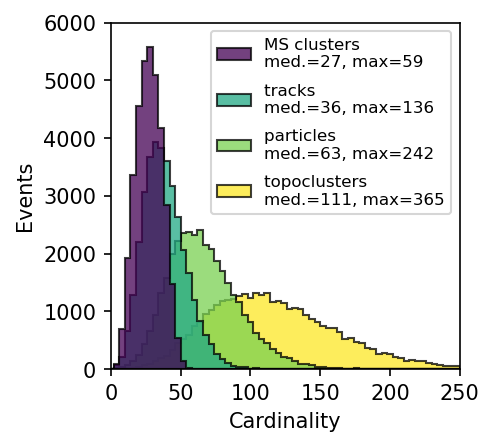

In [135]:
fig = plt.figure(figsize=(3, 3), dpi=150)
gs = GridSpec(1, 1, figure=fig, hspace=0.3, wspace=0.3)

N_max = 250
bin_width = 4
bins = np.linspace(-0.5, N_max + 0.5, (N_max + 2)) * bin_width
bins = bins[bins<=N_max+bin_width]

colors = plt.cm.viridis(np.linspace(0, 1, 6)) #[::-1]
opacity = 0.75
do_log = False

def get_legend_stats(arr):
    return f'med.={np.median(arr):.0f}, max={np.max(arr):.0f}'
    # return f'med.={np.median(arr):.0f}, IQR={np.percentile(arr, 75) - np.percentile(arr, 25):.0f}, max={np.max(arr):.0f}'

plt.hist(cardinality_dict['n_topoclusters'], bins=bins, alpha=opacity, label='topoclusters \n' + get_legend_stats(cardinality_dict["n_topoclusters"]), histtype='stepfilled', edgecolor='black', color=colors[5])
plt.hist(cardinality_dict['n_particles'], bins=bins, alpha=opacity,    label='particles    \n' + get_legend_stats(cardinality_dict["n_particles"]), histtype='stepfilled', edgecolor='black', color=colors[4])
plt.hist(cardinality_dict['n_tracks'], bins=bins, alpha=opacity,       label='tracks       \n' + get_legend_stats(cardinality_dict["n_tracks"]), histtype='stepfilled', edgecolor='black', color=colors[3])
plt.hist(cardinality_dict['n_ms_clusters'], bins=bins, alpha=opacity,  label='MS clusters  \n' + get_legend_stats(cardinality_dict["n_ms_clusters"]), histtype='stepfilled', edgecolor='black', color=colors[0])

plt.xlabel('Cardinality')
plt.ylabel('Events')
plt.xlim(0, N_max)
if do_log:
    plt.ylim(0.5, 1e4)
    plt.yscale('log')
else:
    plt.ylim(0, 6000)

# legend with entries in reverse order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=8, labelspacing=0.8)

plt.show()

In [136]:
fig.savefig('cardinality_distributions.png', dpi=300, bbox_inches='tight')